# HW -2

rc47878

# Imports and Helper Functions

In [1]:
import numpy as np
import gurobi as gb
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.optimize import minimize
from tqdm import tqdm
from numpy.random import normal, randint

GUROBI_TIMEOUT = 5 # in second

%matplotlib inline

In [2]:
# Helper Functions

class Gurobi_Model():
    '''
        Class Method I made to help me encapsulate the whole Gurobi model creation, 
        Finding Slack Variable and perform sensitivity analysis
    '''
    
    def __init__(self, obj_linear, cons, sense, b, variable_types = 'C',
                lower_bound = None, upper_bound = None,
                optimisation_type = gb.GRB.MAXIMIZE, obj_quadratic = None) -> None:
        '''
            Initialising the Model
        '''
        if (obj_quadratic is None) and (obj_linear is None):
            raise Exception("No objective defined")

        constraints, variables = cons.shape

        ## Optimisation Model at work (Maximise)
        try:
            self.model = gb.Model()
            self.model_X = self.model.addMVar(variables,
                                        vtype=variable_types,
                                        lb= lower_bound, ub= upper_bound)

            self.model_constraints = self.model.addMConstr(cons, self.model_X, sense, b)
            self.model.setMObjective(obj_quadratic, obj_linear, 0, sense=optimisation_type)
            self.model.Params.OutputFlag = 0
            self.model.Params.TimeLimit = GUROBI_TIMEOUT

            self.model.optimize()

        except Exception:
            print("Error in optimising")
            raise Exception
        
        ## Assigning stuff for other use cases
        try:
            self.obj_q = obj_quadratic
            self.obj = obj_linear
            self.constraint = cons
            self.sense = sense
            self.b = b
        except Exception:
            print("Error in Storing equations")
            raise Exception
        return

    @property
    def optimal_obj(self): return self.model.objVal

    @property
    def optimal_x(self): return self.model_X.x

    @property
    def output(self):
        return {'objVal': self.optimal_obj,
                'x': self.optimal_x}

    def print_equations(self)->None:
        '''
            Print Objective Functions and Constraint Equations
        '''
        char = "a"
        print("Optimise System of equations:")
        for item in self.obj:
            print(str(item)+char,end=" + ")
            char = chr(ord(char) + 1)
        print("\b\b")
        print("Subject to:")#, end=" ")
        for i in range(self.constraint.shape[0]):
            char = "a"
            print("\t"+str(i)+")",end=" ")
            for j in range(self.constraint.shape[1]):
                print(str(self.constraint[i,j])+char,end=" + ")
                char = chr(ord(char) + 1)
            print("\b\b "+self.sense[i]+"= "+str(self.b[i]))
        return

    def print_slack(self)->None:
        '''
            Print Slacks for each constraints
        '''
        print("\nConstraint values at Optimal solution:\n",self.constraint@self.optimal_x)
        print("Binding values:", self.b)
        print("Slack: ", abs((self.constraint@self.optimal_x)-self.b))
        return

    def sensitivity_analysis(self, verbose = False)->None:
        '''
            Sensitivity Analysis
        '''
        shadow_cost = {index: con.Pi for index, con in enumerate(self.model_constraints)}
        shadow_cost_bound = {index: (con.SARHSLow, con.SARHSUp) for index, con in enumerate(self.model_constraints)}
        if verbose:
            try:
                print("\nShadow Cost:")
                # shadow_cost = [con.Pi for con in self.model_constraints]
                print("\t", shadow_cost)
            except:
                print("\tCan not fetch value for Shadow Cost")

            try:
                print("\nUpper and Lower Bound of Shadow Cost")
                # shadow_cost_bound = [(con.SARHSLow, con.SARHSUp) for con in self.model_constraints]
                print("\t", shadow_cost_bound)
            except:
                print("\tCan not fetch value for Upper and Lower")

            try:
                print("\nRange of Objective where Optimal Corner remains the same")
                print("\tLower Bound:",self.model_X.SAObjLow)# <- Range of Slope for which optimal Corner remains same
                print("\tUpper Bound:",self.model_X.SAObjUP) # <- Range of Slope for which optimal Corner remains same
            except:
                print("\tCan not fetch value for Optimal Corner")        

        return {
            'shadow_cost': shadow_cost,
            'shadow_cost_bound': shadow_cost_bound,
            'optimal_corner_range': {"low": self.model_X.SAObjLow,
                                    'high': self.model_X.SAObjUP}
        }

# Question 1

Use 2019 stock data _(stocks2019.csv)_ to find a portfolio that maximizes expected return while maintaining that no more than 100 days have a negative return.  Short selling is not allowed.  Apply this portfolio to 2020 data _(stocks2020.csv)_, how many days in 2020 had negative returns?

 

To solve this problem set your objective to be the mean return of your portfolio.  Then define a binary variable for each days' return that takes on the value 1 if that day's return is negative, and 0 if it's positive (enforce this with a big-M constraint) and then add a constraint that the sum of these binary variables must be less than or equal to 100.  This is an integer programming problem.

In [3]:
stocks2019 = pd.read_csv('stocks2019.csv')
stocks2019.X = pd.to_datetime(stocks2019.X)
stocks2019.set_index('X', inplace= True)
#Changing price levels to returns and discarding first row
stocks2019 = np.round(stocks2019.pct_change(),4).iloc[1:]
stocks2019 = stocks2019
print(f'The Stocks Dataset has {stocks2019.shape[0]} days data for {stocks2019.shape[1] - 1} stocks following the "NDX" index')
stocks2019.drop(['NDX'], axis = 1, inplace = True)
stocks2019.head()

The Stocks Dataset has 250 days data for 100 stocks following the "NDX" index


,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.0355,-0.0395,-0.0945,0.0220,-0.0858,-0.0277,-0.0285,-0.0252,-0.0152,-0.0604,...,-0.0228,-0.0186,-0.0350,-0.0306,-0.0021,-0.0104,-0.0358,-0.0682,-0.0039,-0.0377
2019-01-04,0.0399,0.0486,0.1144,0.0578,0.0104,0.0513,0.0538,0.0501,0.0342,0.0243,...,0.0590,0.0480,0.0447,0.0441,0.0548,0.0333,0.0606,0.0424,0.0098,0.0463
2019-01-07,0.0282,0.0136,0.0826,0.0183,0.0172,-0.0020,-0.0022,0.0344,0.0135,0.0063,...,0.0221,0.0626,0.0163,0.0010,0.0182,0.0057,0.0009,0.0355,-0.0043,0.0264
2019-01-08,0.0303,0.0149,0.0088,0.0062,0.0160,0.0088,0.0074,0.0166,0.0128,0.0244,...,0.0103,0.0185,0.0365,0.0089,0.0133,0.0200,0.0211,-0.0096,0.0116,-0.0191
2019-01-09,0.0172,0.0118,-0.0270,0.0124,0.0382,-0.0034,-0.0015,0.0017,-0.0012,0.0253,...,0.0237,0.0188,-0.0082,0.0038,0.0231,0.0121,-0.0046,0.0441,-0.0080,0.0090


Objective: Maximise Portfolio Returns s.t. Returns can not be -ve for ≥ 100 days

Let portfolio return $P$ be defined as:
$$P = w_0x_0 + w_1x_1 + ... + w_{n-1}x_{n-1} + w_nx_n$$
$$Or,\text{  }P = W^T.X$$
where $W^T$ are the weights of each stock

And, $X$ is a vector of stock returns

We know:
- $\sum_{i=0}^n w_i = 1$

In [4]:
num_days, num_stocks = stocks2019.shape
# print(num_days, num_stocks)
M = 100
#obj = 250 binary var.(+ve/-ve return) + 250 continuous var.(avg. profit) + 100 continuous var.(stock return)
obj = np.array([0]*num_days + stocks2019.mean().to_list())
variables = obj.shape[0]
constraints = 2*num_days + 2

A = np.zeros((constraints, variables))
b = np.zeros(constraints)
sense = np.array(['<']*constraints)

for day in range(0,num_days):
    # Big M constraints
    A[ 2*day , day ] = M
    A[ 2*day , -num_stocks: ] = stocks2019.iloc[day]
    sense[(2*day)] = '>'
    b[2*day] = 0
    
    A[ 2*day + 1 , day ] = M
    A[ 2*day + 1, -num_stocks: ] = stocks2019.iloc[day]
    # sense[2*day + 1] = '<'
    b[2*day + 1] = M
    

# Weight of portfolio = 1 constraint
A[-2,-num_stocks:] = 1
sense[-2] = '='
b[-2] = 1

# -ve Return days Constraint
A[-1,:num_days] = 1
b[-1] = 100

In [5]:
model_1 = Gurobi_Model(obj_linear= obj,
                        cons= A,
                        sense= sense,
                        b = b,
                        variable_types= ['B']*num_days + ['C']*(num_stocks)
                    )
# model_1.print_equations()
print(f'Opimal Profit: {model_1.optimal_obj}')
response = model_1.model_X.x[-num_stocks:]
response.sum()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-25
Opimal Profit: 0.003832930774458102


1.0000000000000002

#### Applying Portfolio in 2020 dataset

In [6]:
stocks2020 = pd.read_csv('stocks2020.csv').drop(['Unnamed: 0','NDX'], axis = 1).pct_change().dropna()
stocks2020

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
1,0.000341,-0.007834,-0.010183,-0.013260,-0.011421,-0.005231,-0.004907,-0.012139,-0.006789,-0.017604,...,-0.021369,-0.017207,0.021095,0.009728,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.023020
2,0.018238,0.005726,-0.004321,0.001598,0.019398,0.026654,0.024657,0.014886,0.007674,-0.011749,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,-0.020844
3,0.010043,-0.000959,-0.002893,0.002533,-0.009864,-0.001932,-0.000624,0.002092,-0.009405,0.022751,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005035,0.020414,0.067698,-0.002077,0.022830
4,-0.007623,0.013438,-0.008705,0.016191,0.010386,0.007118,0.007880,-0.007809,0.000756,0.009032,...,-0.012323,0.019400,0.004626,0.009208,0.032620,-0.058357,0.033304,0.014484,-0.000961,-0.002815
5,-0.009018,0.007636,0.023834,0.019893,0.036853,0.010498,0.011044,0.004799,0.002980,0.000000,...,0.006781,0.021318,0.023169,0.009638,-0.003592,-0.020598,0.004309,-0.000291,0.002244,0.023493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.008835,-0.014400,-0.017282,-0.003706,-0.021599,0.004656,0.005152,-0.006627,0.008824,-0.007347,...,-0.009712,0.012713,-0.010770,-0.009706,0.004002,0.015279,-0.034729,0.004224,-0.008021,-0.015053
248,0.008314,0.005937,0.002840,-0.003981,0.005771,0.003431,0.003735,-0.003949,-0.000045,0.008728,...,-0.019614,-0.014229,0.002710,0.006301,-0.005851,-0.006270,0.000000,-0.000200,0.004976,0.000000
249,0.005167,-0.001820,-0.002287,0.011335,-0.013579,0.022951,0.021416,0.035071,0.003230,0.001454,...,-0.002813,0.051126,0.010299,0.033544,-0.008488,0.001010,-0.027496,0.002805,0.010676,-0.003310
250,-0.000656,0.006333,-0.010699,0.006414,-0.000787,-0.009132,-0.009780,0.011584,0.014397,-0.007050,...,0.004075,-0.002984,-0.005397,-0.011107,0.004388,-0.006304,-0.017361,-0.035358,0.001531,-0.011447


In [7]:
print(f'Number of days in 2020 with negative returns: {len(np.where(stocks2020@response < 0)[0])}')

Number of days in 2020 with negative returns: 115


# Question 2

You are the publisher for 5 local newspapers.  The previous 50 days worth of demand is included in the following file

_hw2_demand.csv_

It costs you $0.50, $0.50, $0.25, $0.75, $0.25  to print each copy of each of the 5 newspapers.

The newspapers sell for $1.25, $1.20, $0.50, $1.50, $0.60 each.

 

Solve the multi-product newsvendor problem.

 
How much profits do you expect to make tomorrow?  Round to the nearest cent.

In [1]:
demand = pd.read_csv('hw2_demand.csv')
cost = pd.Series([0.5, 0.5, 0.25, 0.75, 0.25], index= demand.columns)
sale = pd.Series([1.25, 1.20, 0.50, 1.50, 0.60], index= demand.columns)
# demand = demand[:3]
demand.head()

NameError: name 'pd' is not defined

$$\max_q \text{ Profit}_i = {(\min(quantity,demand_i)*sale - quantity*cost)}$$
By Sample Average Approximation,
$$\max_{q} \text{ Profit}_i = \frac{1}{N}\sum_{i=0}^{N} {(\min(quantity_i,demand_i)*sale - quantity_i*cost)}$$
$$\max_{q} \text{ Profit}_i = \frac{1}{N}\sum_{i=0}^{N} {(\min(quantity_i,demand_i)*sale - quantity_i*cost)}$$

Here Quantity, Cost and sale price are all vectors $\epsilon\text{  } \R^{5x1}$

In [36]:
days = demand.shape[0]
profit = np.zeros(5 + days)
profit[5:] = 1/days # Expected profit is the average of all historic profits
variables = profit.shape[0]
constraints = 2*days

A = np.zeros((constraints, variables))
b = np.zeros(constraints)
sense = ["<"]*constraints

for i in range(days):
    # h + cq ≤ pDi
    A[2*i,[x for x in range(5)]+[5+i]] = cost.to_list()+[1]
    b[2*i] = np.dot(demand.iloc[i], sale)

    # h - (p-c)q ≤ 0 == h + (c-p)q ≤ 0
    A[(2*i)+1,[x for x in range(5)]+[5+i]] = (cost - sale).to_list()+[1]
    b[(2*i)+1] = 0

sense = np.array(sense)
lb = np.zeros(variables)
lb[5:] = -np.inf # daily profits can be -ve but quantity can not be


In [37]:
model_2 = Gurobi_Model(obj_linear= profit,
                        cons= A,
                        sense= sense,
                        b = b,
                        lower_bound= lb)
# model_2.print_equations()

In [38]:
print(f'Expected Profit for tomorrow: {np.round(model_2.optimal_obj, 2)}')

Expected Profit for tomorrow: 526.72


# Question 3

Go back to the saving for retirement problem we did in class.  There's approximately a 55% chance you go bankrupt before you die.  That's not very good.  You should probably keep working for a few more years.  Today you have $2M in your retirement account.  If you keep working, you earn $400k (after taxes) per year, with a 2.5% raise every year.  You still spend $150k per year and when you work, every dollar of salary that you don't spend goes into your retirement account. As in the code from class, each year first grow your portfolio from market returns, then add your salary and give yourself a raise for next year (if you're still working), then subtract your cost of living. You're still going to die 35 years from today.  The market has normal annual returns with mean = 7% and sd = 10%.  What is the smallest number of years you need to work such that your probability of going bankrupt before death is less than 6%?  Use 10000 simulations.

In [12]:
nsim = 10000

death = 35
hike = 0.025
bankrupt_probability = []
portfolio_average = []

for min_years_to_work in tqdm(range(35)):
    # print('Years to work:',min_years_to_work, end= "\t")
    def_vec_rd = np.array([False]*nsim)
    port_val_vec_rd = np.zeros(nsim)
    
    for sim in range(nsim):
        portfolio = 2000000
        salary = 400000
        isWorking = True

        for year in range(death):
            # market returns of 7% with 10% std
            mrkt_return_pct = (np.random.normal(size = 1, loc = 7, scale = 10)/100)[0]

            #grow portfolio
            portfolio *= (1+mrkt_return_pct)

            # Check if working
            if year >= min_years_to_work and isWorking:
                isWorking = np.where(randint(0,1) == 1, True, False)
            
            #Add salary if working
            if isWorking:
                portfolio += salary

                # next year's increment
                salary *= (1+ hike)
            
            #expenses
            portfolio = portfolio - 150000

            if (portfolio <= 0):
                portfolio = 0
            
        if portfolio <= 0:
            def_vec_rd[sim] = True
        port_val_vec_rd[sim] = portfolio

    bankrupt_probability.append(np.mean(def_vec_rd))
    portfolio_average.append(np.mean(port_val_vec_rd))
    if np.mean(def_vec_rd) < 0.06:
        print(f'minimum number of years to work to avoid bankruptcy is:{min_years_to_work}')
        break
# bankrupt_probability

  9%|▊         | 3/35 [00:08<01:27,  2.75s/it]

minimum number of years to work to avoid bankruptcy is:3


Text(0.5, 1.0, 'P(Bankruptcy before 35)')

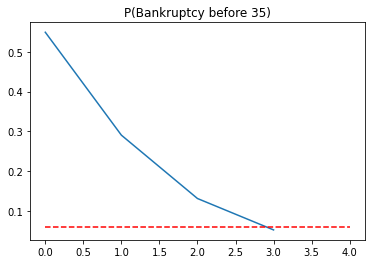

In [13]:
plt.plot(np.array(bankrupt_probability))
plt.hlines(0.06,0, len(bankrupt_probability), linestyles= 'dashed', colors='red')
plt.title("P(Bankruptcy before 35)")

Text(0.5, 1.0, 'Average Portfolio Size')

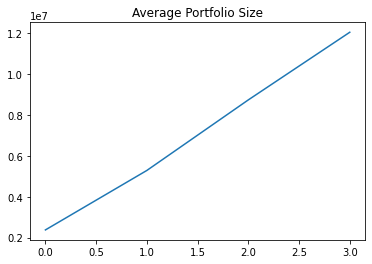

In [14]:
plt.plot(np.array(portfolio_average))
plt.title("Average Portfolio Size")

# Question 4

You manufacture microprocessors.  There are 2 lines of chips: high performance and low performance.  Your manufacturing processes are not perfect though, there are quality issues in your production. There are 2 manufacturing processes you can perform.  One process produces chips where the performance is a normal random variable with mean = 10 and sd = 3, and it costs $10 to manufacture chips using this process.  The other manufacturing process produces chips where the performance is a normal random variable with mean = 5 and sd = 2, and it costs $5 to manufacture chips using this process.  Any chip that has a performance less than 7 must be sold as a low performance chip, and any chip that has a performance above 7 can be sold as a high performance chip.  Low performance chips sell for $8 and high performance chips sell for $15.  There is currently a global chip shortage, so any chip you manufacture will sell immediately.  If you produce 100 chips using the first process and 200 chips using the second process, what is the standard deviation of your profit?  Use 10000 simulations to answer this question.

In [15]:
simulation_count = 10000
profits = np.array([0]*simulation_count)

for i in tqdm(range(simulation_count)):
    process1 = normal(10, 3, 100) # Producing 100 chips using process 1 Normal(mean = 10, sd = 3)
    process2 = normal(5, 2, 200) # Producing 200 chips using process 2 Normal(mean = 5, sd = 2)
    cost_price = np.sum(10*process1.shape[0]) + np.sum(5*process2.shape[0])

    products = np.append(process1, process2)
    # < 7 is low performance. Low sells for $8; high for $15
    sale_price = np.sum(np.where(products < 7, 8, 15))
    profits[i] = sale_price - cost_price

100%|██████████| 10000/10000 [00:00<00:00, 27618.34it/s]


Expected Profit: 1212.3598
Standard Deviation: 44.33877472326


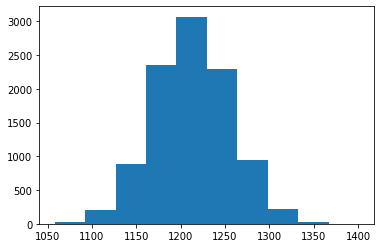

In [16]:
plt.hist(profits)
print(f'Expected Profit: {np.mean(profits)}\nStandard Deviation: {np.std(profits)}')

***